# Notebook 13 c) Multi-class Sentiment Model using ML Models

This notebook uses the noun phrases to run the same machine learning classifiers as used in Notebook 7 (Text Content Sentiment Models). However, the data here is not at review level, it has been split down into sentences and the noun phrases extracted. VADER was used to determine polarity of each noun phrase. 

In this notebook, neutal sentiment is retained to predict a MULTI-CLASS sentiment. This compares to Notebook 12 a) which predicts a binary output, by dropping neutral reviews. Much of this work-book remains the same as 12 a) but outputting one of three outcomes. The classes are sampled to match the minority class, resulting in a dataset of 13,245 reviews (4,415 each of positive, neutral and negative).

* Section 1 - Import libraries and dataset
* Section 2 - Feature Presence Vector (One-hot encoding)
* Section 3 - Feature Presence Vector Bigram
* Section 4 - BOW unigram vector
* Section 5 - BOW bigram vector
* Section 6 - TFIDF unigram vector
* Section 7 - TFIDF bigram vector
* Section 8 - Classification models training accuracy
* Section 9 - Predict on validation set
* Section 10 - Summary Table of Results
* Section 11 - Hyperparameter tuning and grid search cv
* Section 12 - Best model against the unseen test set

Datasets needed to run notebook:

* combined_sentiment.csv
* combined_sentiment_test.csv


# Section 1: Import libraries and dataset

In [2]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, KFold,cross_val_score,learning_curve,validation_curve,GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import imblearn
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, roc_curve,auc,roc_auc_score,precision_recall_curve,plot_precision_recall_curve,f1_score,fbeta_score,f1_score,precision_score,recall_score, average_precision_score
import scipy.sparse
import pickle

In [3]:
# Bring in training and test sets from Notebook 11 (visualising topic models)
df_train = pd.read_csv("combined_sentiment.csv",index_col = 0)
df_test = pd.read_csv("combined_sentiment_test.csv",index_col = 0)

# Combine train and test set
df_combined_all = pd.concat([df_train, df_test],axis = 0,ignore_index = True)
df_combined_all.shape

(73027, 15)

In [4]:
df_combined_all.head(2)

,Unnamed: 0.1,OrigInd,Category,Town,Rating,all_text,cleaned,noun_phrases,nouns,Topic Count,Topic TFIDF,Sentiment,Score,Sentence,Topic
0,0,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...",nice break shame accommodation booked night st...,shame accommodation,"['shame', 'accommodation']",VFM,VisitExp,-0.4767,negative,NaN,NaN
1,1,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...",nice break shame accommodation booked night st...,night stay december post-christmas,"['night', 'post-christmas']",Hotel Location,Restaurant,0.0000,neutral,NaN,NaN


# Section 2: Data processing

In [5]:
df_combined_all.shape

(73027, 15)

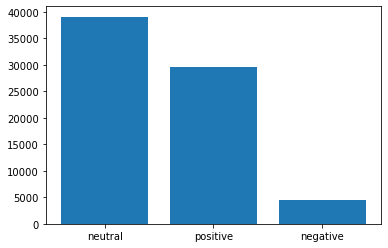

In [6]:
# Distribution of polarities
sent = pd.DataFrame(df_combined_all["Score"].value_counts())
plt.bar(sent.index,sent["Score"])
plt.show()

In [7]:
df_combined_all["Score"].value_counts()

neutral     39099
positive    29513
negative     4415
Name: Score, dtype: int64

In [8]:
neutral_sampled = df_combined_all[df_combined_all["Score"] == "neutral"].sample(4415)
positive_sampled = df_combined_all[df_combined_all["Score"] == "positive"].sample(4415)
negative = df_combined_all[df_combined_all["Score"] == "negative"]
print(neutral_sampled.shape, positive_sampled.shape, negative.shape)

(4415, 15) (4415, 15) (4415, 15)


In [9]:
df_combined = pd.concat([neutral_sampled, positive_sampled, negative], axis = 0, ignore_index = True)
df_combined.shape

(13245, 15)

In [10]:
df_combined["Score"].replace({"positive": 1,"negative":-1,"neutral":0}, inplace=True)
df_combined["Score"].value_counts()

 0    4415
 1    4415
-1    4415
Name: Score, dtype: int64

In [11]:
# Drop the neutral sentiment and set 0 to positive and 1 to negative
#df_combined_all = df_combined_all[df_combined_all["Score"]!="neutral"]
#df_combined_all["Score"].replace({"positive": 0,"negative":1}, inplace=True)
#df_combined_all["Score"].value_counts()

The dataset is imbalanced. Over sampling would create a dataset with a lot of duplicates and under sampling would produce a much smaller dataset. Class weights can be used with all models except Naive Bayes but this would be very intensive since the dataset is so large. Therefore, undersampling of the majority class is chosen as a method to address the imbalance.

In [12]:
X = df_combined["noun_phrases"]
y = df_combined["Score"]

In [13]:
print(X.shape, y.shape)

(13245,) (13245,)


In [14]:
y.value_counts()

 0    4415
 1    4415
-1    4415
Name: Score, dtype: int64

In [15]:
X = np.array(X).reshape(-1, 1)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y,test_size=0.2, shuffle = True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,stratify = y_test, test_size=0.50, shuffle = True) 

In [17]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(10596, 1) (10596,) (1325, 1) (1325,) (1324, 1) (1324,)


In [18]:
y_train.value_counts()

 0    3532
 1    3532
-1    3532
Name: Score, dtype: int64

In [19]:
# Reformat to the right shape
X_train = [item for sublist in X_train for item in sublist]
X_val = [item for sublist in X_val for item in sublist]
X_test = [item for sublist in X_test for item in sublist]

# Section 2: Feature Presence (One-Hot Encoding)

In [20]:
# Apply to training dataset and valuation dataset - not binary set to true for one hot encoded feature presence vector
vectorizer1 = CountVectorizer(max_df=1.0, min_df=1,stop_words = "english", binary = True)
vectorizer1.fit(X_train)

# Transform the training and test set to vectors
X_train_fp = vectorizer1.transform(X_train)
X_val_fp = vectorizer1.transform(X_val)
X_test_fp = vectorizer1.transform(X_test)

In [21]:
# Size of training and test sets. The number of columns is the number of words in the document term matrix
print(X_train_fp.shape, X_val_fp.shape)

(10596, 4169) (1325, 4169)


# Section 3: Feature Presence Bigram Model

In [22]:
# Apply to training dataset and valuation dataset
vectorizer2 = CountVectorizer(max_df=1.0, min_df=1,stop_words = "english", binary = True, ngram_range=(1, 2))
vectorizer2.fit(X_train)

# Transform the training and test set to vectors
X_train_fp_big = vectorizer2.transform(X_train)
X_val_fp_big = vectorizer2.transform(X_val)
X_test_fp_big = vectorizer2.transform(X_test)

In [23]:
# Size of training and test sets. The number of columns is the number of words in the document term matrix
print(X_train_fp_big.shape, X_val_fp_big.shape)

(10596, 18547) (1325, 18547)


# Section 4: Count Frequency Model

In [24]:
# Apply to training dataset and valuation dataset
vectorizer3 = CountVectorizer(max_df=1.0, min_df=1,stop_words = "english")
vectorizer3.fit(X_train)

# Transform the training and test set to vectors
X_train_bow = vectorizer3.transform(X_train)
X_val_bow = vectorizer3.transform(X_val)
X_test_bow = vectorizer3.transform(X_test)

In [25]:
# Size of training and test sets. The number of columns is the number of words in the document term matrix
print(X_train_bow.shape, X_val_bow.shape, y_train.shape, y_val.shape)

(10596, 4169) (1325, 4169) (10596,) (1325,)


# Section 5: Countvectorizer Bigram Model

In [26]:
# Apply to whole dataset with unigrams and bigrams. Set up ngram vectorizer and fit to training data
# words must appear in at least 2 documents and not in more than 98% of documents to limit the vocabulary size
vectorizer4 = CountVectorizer(analyzer='word', max_df = 1.0, min_df = 1,stop_words = "english",ngram_range=(1,2))
vectorizer4.fit(X_train)

# Transform the training and test set to vectors for use in model training and predicting
X_train_ngram = vectorizer4.transform(X_train)
X_val_ngram = vectorizer4.transform(X_val)
X_test_ngram = vectorizer4.transform(X_test)

In [27]:
# Size of training and test sets. The number of columns is the number of words in the document term matrix. Ten times as many
# words and ngrams in the training and test set compared to the BOW model
print(X_train_ngram.shape, X_val_ngram.shape, y_train.shape, y_val.shape)

(10596, 18547) (1325, 18547) (10596,) (1325,)


# Section 6 :TFIDF Vectorizer - Unigram Model

In [28]:
# Set up countvectorizer based on ngrams for the whole corpus based on unigrams only and fit to training set
vectorizer5 = TfidfVectorizer(use_idf = True, max_df = 1.0,min_df = 1, stop_words = "english",smooth_idf = True, norm = 'l2')
np.set_printoptions(precision = 2)
vectorizer5.fit(X_train)

TfidfVectorizer(stop_words='english')

In [29]:
# Function to save tokenizer object
def save_tok(name,file):
    with open(name, 'wb') as handle:
        pickle.dump(file, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [30]:
# Transform the training and test set to vectors for use in model training and predicting
X_train_tfidf1 = vectorizer5.transform(X_train)
X_val_tfidf1 = vectorizer5.transform(X_val)
X_test_tfidf1 = vectorizer5.transform(X_test)

In [31]:
# Size of training and test sets. The number of columns is the number of words in the document term matrix.Same as BOW
print(X_train_tfidf1.shape, X_val_tfidf1.shape, y_train.shape, y_val.shape)

(10596, 4169) (1325, 4169) (10596,) (1325,)


# Section 7: TFIDF - BIGRAM MODEL

In [32]:
# Set up countvectorizer based on ngrams for the whole corpus based on unigrams only and fit to training set
vectorizer6 = TfidfVectorizer(use_idf = True, max_df = 0.98,min_df =2,stop_words = "english",ngram_range=(1,2),smooth_idf = True, norm = 'l2')
np.set_printoptions(precision = 2)
vectorizer6.fit(X_train)

TfidfVectorizer(max_df=0.98, min_df=2, ngram_range=(1, 2), stop_words='english')

In [33]:
# Function to save tokenizer objects
def save_tok(name,file):
    with open(name, 'wb') as handle:
        pickle.dump(file, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [34]:
# Transform the training and test set to vectors for use in model training and predicting
X_train_tfidf2 = vectorizer6.transform(X_train)
X_val_tfidf2 = vectorizer6.transform(X_val)
X_test_tfidf2 = vectorizer6.transform(X_test)

In [35]:
# Size of training and test sets. The number of columns is the number of words in the document term matrix.Same as BOW
print(X_train_tfidf2.shape, X_val_tfidf2.shape, y_train.shape, y_val.shape)

(10596, 4046) (1325, 4046) (10596,) (1325,)


# Section 8: Training Accuracy on Each of the Vectorizer Objects

In [36]:
# Set models - linear kernel set as a little quicker
dummy_model = DummyClassifier(strategy ='uniform')
nb = MultinomialNB()
lr = LogisticRegression(max_iter = 200)
rf = RandomForestClassifier()
svm = SVC(kernel = "linear", probability = True)

In [36]:
# Function to train with specified model on the training set - 10 fold as the dataset for ngrams is very large

def train_accuracy(model,X,y,vector):
    kf = KFold(n_splits = 10, shuffle = True, random_state = 1)
    cv_results = cross_val_score(model, X, y, cv = kf, scoring = "accuracy", n_jobs =-1)
    train_accuracy.results = pd.DataFrame({vector:cv_results.mean()}, index = [0])
                                

## Dummy Classifier

In [37]:
# BOW
train_accuracy(dummy_model,X_train_bow,y_train,"BOW-dum")
dum_train_bow = train_accuracy.results
dum_train_bow

,BOW-dum
0,0.334747


## Naive Bayes

In [38]:
# Feature Presence
train_accuracy(nb,X_train_fp, y_train, "FP")
nb_train_fp = train_accuracy.results

# Feature Presence Bigram
train_accuracy(nb,X_train_fp_big, y_train, "FP BIG")
nb_train_fp_big = train_accuracy.results

# BOW
train_accuracy(nb,X_train_bow,y_train,"BOW")
nb_train_bow = train_accuracy.results

# ngram
train_accuracy(nb,X_train_ngram,y_train,"BIGRAM")
nb_train_ngram = train_accuracy.results

# TFIDF unigram
train_accuracy(nb,X_train_tfidf1,y_train,"TFIDF UNI")
nb_train_tfidf1 = train_accuracy.results

# TFIDF bigram
train_accuracy(nb,X_train_tfidf2,y_train,"TFIDF BI")
nb_train_tfidf2 = train_accuracy.results

## Logistic Regression

In [39]:
# Feature Presence
train_accuracy(lr,X_train_fp, y_train, "FP")
lr_train_fp = train_accuracy.results

# Feature Presence Bigram
train_accuracy(lr,X_train_fp_big, y_train, "FP BIG")
lr_train_fp_big = train_accuracy.results

# BOW
train_accuracy(lr,X_train_bow,y_train,"BOW")
lr_train_bow = train_accuracy.results

# ngrams
train_accuracy(lr,X_train_ngram,y_train,"BIGRAM")
lr_train_ngram = train_accuracy.results

# TFIDF unigrams
train_accuracy(lr,X_train_tfidf1,y_train,"TFIDF UNI")
lr_train_tfidf1 = train_accuracy.results

# TFIDF bigrams
train_accuracy(lr,X_train_tfidf2,y_train,"TFIDF BI")
lr_train_tfidf2 = train_accuracy.results

## Random Forest

In [40]:
# Feature Presence
train_accuracy(rf,X_train_fp, y_train, "FP")
rf_train_fp = train_accuracy.results

# Feature Presence Bigram
train_accuracy(rf,X_train_fp_big, y_train, "FP BIG")
rf_train_fp_big = train_accuracy.results

# BOW
train_accuracy(rf,X_train_bow,y_train,"BOW")
rf_train_bow = train_accuracy.results

# bigrams
train_accuracy(rf,X_train_ngram,y_train,"BIGRAM")
rf_train_ngram = train_accuracy.results

# TFIDF unigrams
train_accuracy(rf,X_train_tfidf1,y_train,"TFIDF UNI")
rf_train_tfidf1 = train_accuracy.results

# TFIDF bigrams
train_accuracy(rf,X_train_tfidf2,y_train,"TFIDF BI")
rf_train_tfidf2 = train_accuracy.results

## SVM

In [41]:
# Feature Presence
train_accuracy(svm,X_train_fp, y_train, "FP")
svm_train_fp = train_accuracy.results

# Feature Presence Bigram
train_accuracy(svm,X_train_fp_big, y_train, "FP BIG")
svm_train_fp_big = train_accuracy.results

# BOW
train_accuracy(svm,X_train_bow,y_train,"BOW")
svm_train_bow = train_accuracy.results

# bigrams
train_accuracy(svm,X_train_ngram,y_train,"BIGRAM")
svm_train_ngram = train_accuracy.results

# TFIDF unigrams
train_accuracy(svm,X_train_tfidf1,y_train,"TFIDF UNI")
svm_train_tfidf1 = train_accuracy.results

# TFIDF bigrams
train_accuracy(svm,X_train_tfidf2,y_train,"TFIDF BI")
svm_train_tfidf2 = train_accuracy.results

In [42]:
models = ["Multinomial NB","Logistic Regression","Random Forest","SVM"]
fp = pd.concat([nb_train_fp, lr_train_fp, rf_train_fp, svm_train_fp])
fp_big = pd.concat([nb_train_fp_big, lr_train_fp_big, rf_train_fp_big, svm_train_fp_big])
bow = pd.concat([nb_train_bow,lr_train_bow,rf_train_bow,svm_train_bow])
big = pd.concat([nb_train_ngram,lr_train_ngram,rf_train_ngram,svm_train_ngram])
tfidf = pd.concat([nb_train_tfidf1,lr_train_tfidf1,rf_train_tfidf1,svm_train_tfidf1])
tfidf_big = pd.concat([nb_train_tfidf2,lr_train_tfidf2,rf_train_tfidf2,svm_train_tfidf2])

In [43]:
all_models = pd.concat([fp,fp_big,bow,big,tfidf,tfidf_big],axis = 1)
all_models.set_index([models],inplace = True)
all_models

,FP,FP BIG,BOW,BIGRAM,TFIDF UNI,TFIDF BI
Multinomial NB,0.861079,0.857965,0.859192,0.858060,0.861929,0.863061
Logistic Regression,0.919310,0.907041,0.919593,0.907419,0.905059,0.903360
Random Forest,0.907041,0.897319,0.908550,0.898547,0.928276,0.923839
SVM,0.942053,0.927048,0.942619,0.926765,0.925255,0.922424


SVM TFIDF BOW has the best training accuracy

# Section 9: Prediction on validation set with each of the Models

In [46]:
def prediction(model,X_train,y_train,X_val,y_val):
    labels = ["negative","neutral","positive"]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_val)
    target_probs = model.predict_proba(X_val)
    #y_class = np.argmax(y_pred, axis = 0)
    print(classification_report(y_val, y_pred))
    conf_mat = confusion_matrix(y_val, y_pred)
    fig, ax = plt.subplots(figsize=(8,6))
    ax = sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels = labels, yticklabels = labels,cmap = plt.cm.Blues)
    ax.set_ylabel('Actual',labelpad = 10)
    ax.set_xlabel('Predicted', labelpad = 13)
    
    # Test Set Metrics
    accuracy = accuracy_score(y_val, y_pred)
    rocauc = roc_auc_score(y_val,target_probs, multi_class='ovr') # weights not required as dataset is balanced
    precision = precision_score(y_val, y_pred, average = "macro")
    recall = recall_score(y_val, y_pred, average = "macro")
    f1 = f1_score(y_val, y_pred, average = "macro")
    prediction.results = pd.DataFrame({"Accuracy":accuracy, "Precision":precision, "Recall":recall,
                                    "F1":f1,"ROCAUC":rocauc}, index = [0]
                                  )
        
    plt.show()
    


## Feature Presence

### Naive Bayes

              precision    recall  f1-score   support

          -1       0.84      0.90      0.87       441
           0       0.86      0.73      0.79       442
           1       0.86      0.93      0.89       442

    accuracy                           0.85      1325
   macro avg       0.85      0.85      0.85      1325
weighted avg       0.85      0.85      0.85      1325



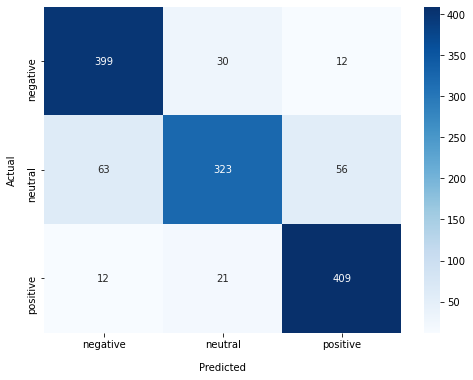

In [45]:
y_pred1 = prediction(nb,X_train_fp,y_train,X_val_fp,y_val)

In [46]:
mod1 = prediction.results
mod1

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.853585,0.854293,0.853585,0.851283,0.969222


### Logistic Regression

              precision    recall  f1-score   support

          -1       0.97      0.90      0.93       441
           0       0.84      0.98      0.91       442
           1       0.98      0.90      0.94       442

    accuracy                           0.92      1325
   macro avg       0.93      0.92      0.93      1325
weighted avg       0.93      0.92      0.93      1325



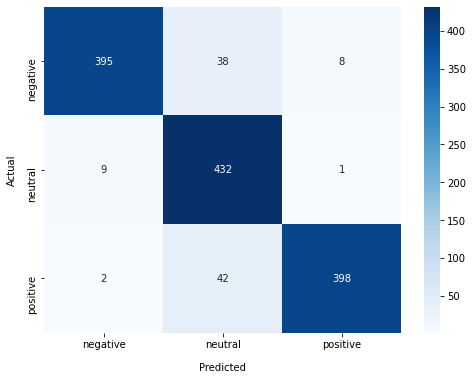

In [47]:
y_pred2 = prediction(lr,X_train_fp,y_train,X_val_fp,y_val)

In [48]:
mod2 = prediction.results
mod2

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.924528,0.931483,0.924528,0.925307,0.98237


### Random Forest

              precision    recall  f1-score   support

          -1       0.91      0.91      0.91       441
           0       0.88      0.92      0.90       442
           1       0.96      0.93      0.94       442

    accuracy                           0.92      1325
   macro avg       0.92      0.92      0.92      1325
weighted avg       0.92      0.92      0.92      1325



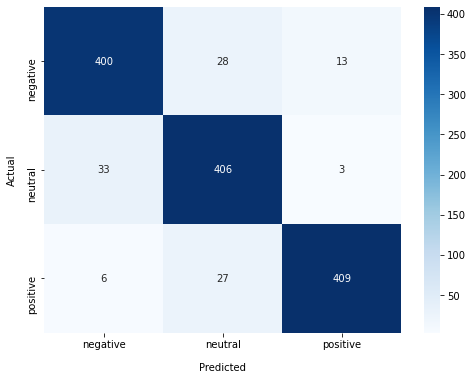

In [49]:
y_pred3 = prediction(rf,X_train_fp,y_train,X_val_fp,y_val)

In [50]:
mod3 = prediction.results
mod3

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.916981,0.918075,0.916981,0.917273,0.9745


### Support Vector Machines

              precision    recall  f1-score   support

          -1       0.99      0.91      0.95       441
           0       0.89      0.98      0.93       442
           1       0.97      0.94      0.96       442

    accuracy                           0.94      1325
   macro avg       0.95      0.94      0.95      1325
weighted avg       0.95      0.94      0.95      1325



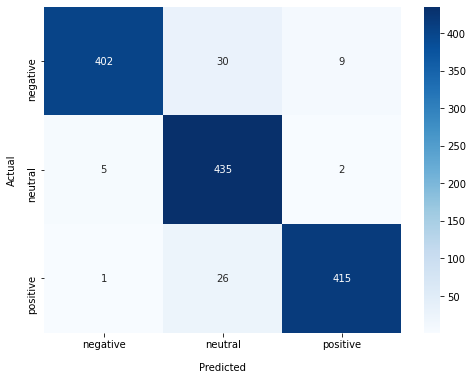

In [51]:
prediction(svm,X_train_fp,y_train,X_val_fp,y_val)

In [52]:
mod4 = prediction.results
mod4

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.944906,0.948445,0.944906,0.94523,0.983808


## Feature Presence Bigram

### Naive Bayes

              precision    recall  f1-score   support

          -1       0.85      0.90      0.87       441
           0       0.85      0.74      0.80       442
           1       0.86      0.92      0.89       442

    accuracy                           0.86      1325
   macro avg       0.86      0.86      0.85      1325
weighted avg       0.86      0.86      0.85      1325



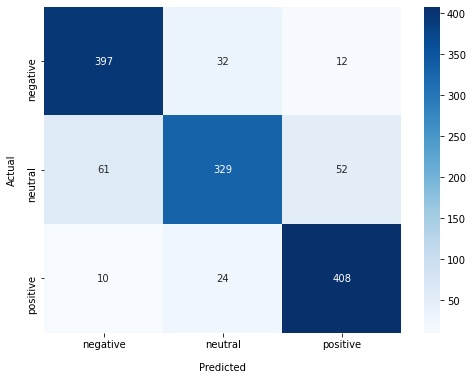

In [53]:
prediction(nb,X_train_fp_big,y_train,X_val_fp_big,y_val)

In [54]:
mod5 = prediction.results
mod5

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.855849,0.855753,0.855849,0.853956,0.965757


### Logistic Regression

              precision    recall  f1-score   support

          -1       0.98      0.87      0.92       441
           0       0.82      0.98      0.90       442
           1       0.98      0.90      0.94       442

    accuracy                           0.92      1325
   macro avg       0.93      0.92      0.92      1325
weighted avg       0.93      0.92      0.92      1325



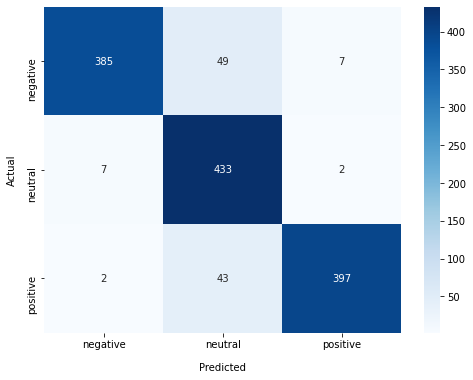

In [55]:
prediction(lr,X_train_fp_big,y_train,X_val_fp_big,y_val)

In [56]:
mod6 = prediction.results
mod6

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.916981,0.926546,0.916981,0.918007,0.980541


### Random Forest

              precision    recall  f1-score   support

          -1       0.92      0.90      0.91       441
           0       0.86      0.93      0.89       442
           1       0.97      0.90      0.93       442

    accuracy                           0.91      1325
   macro avg       0.92      0.91      0.91      1325
weighted avg       0.92      0.91      0.91      1325



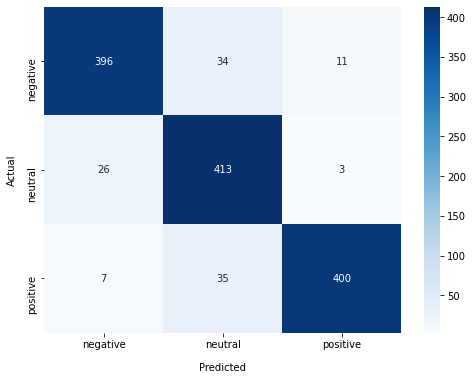

In [57]:
prediction(rf,X_train_fp_big,y_train,X_val_fp_big,y_val)

In [58]:
mod7 = prediction.results
mod7

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.912453,0.915363,0.912453,0.912957,0.972867


### Support Vector Machines

              precision    recall  f1-score   support

          -1       0.98      0.90      0.94       441
           0       0.87      0.98      0.92       442
           1       0.98      0.92      0.95       442

    accuracy                           0.94      1325
   macro avg       0.94      0.94      0.94      1325
weighted avg       0.94      0.94      0.94      1325



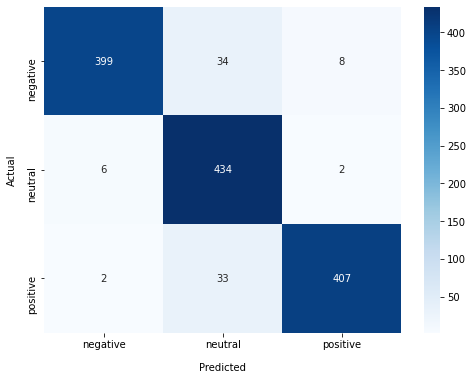

In [59]:
prediction(svm,X_train_fp_big,y_train,X_val_fp_big,y_val)

In [60]:
mod8 = prediction.results
mod8

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.935849,0.940847,0.935849,0.936369,0.983461


## BOW

### Naive Bayes

              precision    recall  f1-score   support

          -1       0.84      0.91      0.87       441
           0       0.86      0.73      0.79       442
           1       0.86      0.92      0.89       442

    accuracy                           0.86      1325
   macro avg       0.86      0.86      0.85      1325
weighted avg       0.86      0.86      0.85      1325



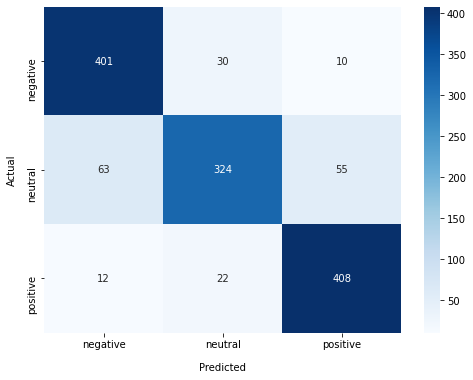

In [61]:
prediction(nb,X_train_bow,y_train,X_val_bow,y_val)

In [62]:
mod9 = prediction.results
mod9

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.855094,0.855583,0.855094,0.85284,0.96877


### Logistic Regression

              precision    recall  f1-score   support

          -1       0.97      0.90      0.93       441
           0       0.84      0.98      0.91       442
           1       0.98      0.90      0.94       442

    accuracy                           0.92      1325
   macro avg       0.93      0.92      0.93      1325
weighted avg       0.93      0.92      0.93      1325



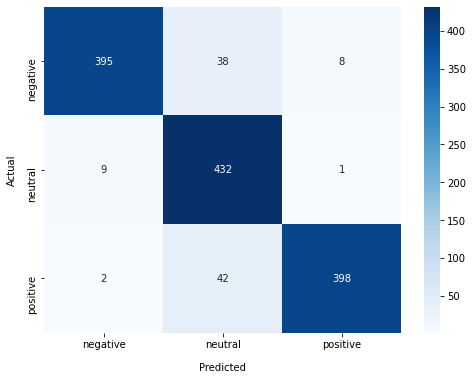

In [63]:
prediction(lr,X_train_bow,y_train,X_val_bow,y_val)

In [64]:
mod10 = prediction.results
mod10

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.924528,0.931483,0.924528,0.925307,0.981869


### Random Forest

              precision    recall  f1-score   support

          -1       0.91      0.90      0.91       441
           0       0.87      0.92      0.90       442
           1       0.96      0.92      0.94       442

    accuracy                           0.91      1325
   macro avg       0.92      0.91      0.92      1325
weighted avg       0.92      0.91      0.92      1325



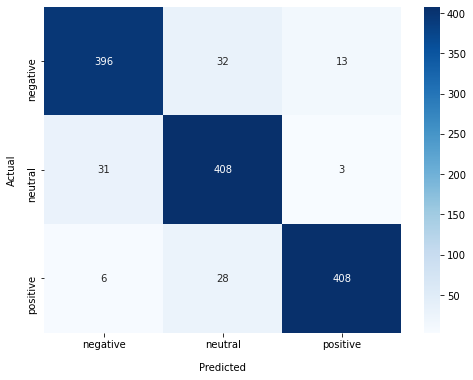

In [65]:
prediction(rf,X_train_bow,y_train,X_val_bow,y_val)

In [66]:
mod11 = prediction.results
mod11

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.914717,0.916204,0.914717,0.915055,0.975065


### SVM

              precision    recall  f1-score   support

          -1       0.99      0.91      0.95       441
           0       0.89      0.98      0.93       442
           1       0.97      0.94      0.96       442

    accuracy                           0.94      1325
   macro avg       0.95      0.94      0.95      1325
weighted avg       0.95      0.94      0.95      1325



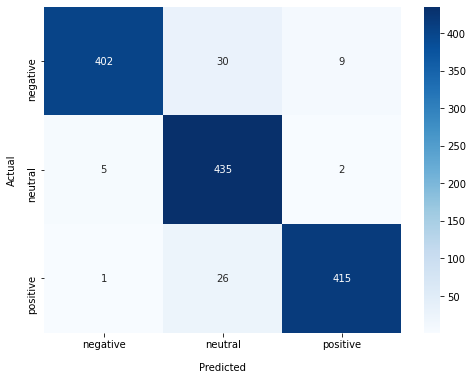

In [67]:
prediction(svm,X_train_bow,y_train,X_val_bow,y_val)

In [68]:
mod12 = prediction.results
mod12

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.944906,0.948445,0.944906,0.94523,0.983321


## NGRAMs

### Naive Bayes

              precision    recall  f1-score   support

          -1       0.85      0.90      0.87       441
           0       0.86      0.75      0.80       442
           1       0.87      0.92      0.89       442

    accuracy                           0.86      1325
   macro avg       0.86      0.86      0.86      1325
weighted avg       0.86      0.86      0.86      1325



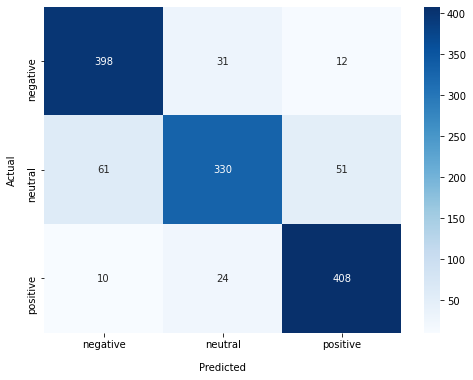

In [69]:
prediction(nb,X_train_ngram,y_train,X_val_ngram,y_val)

In [70]:
mod13 = prediction.results
mod13

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.857358,0.85734,0.857358,0.855501,0.965188


### Logistic Regression

              precision    recall  f1-score   support

          -1       0.98      0.88      0.93       441
           0       0.83      0.98      0.90       442
           1       0.98      0.90      0.94       442

    accuracy                           0.92      1325
   macro avg       0.93      0.92      0.92      1325
weighted avg       0.93      0.92      0.92      1325



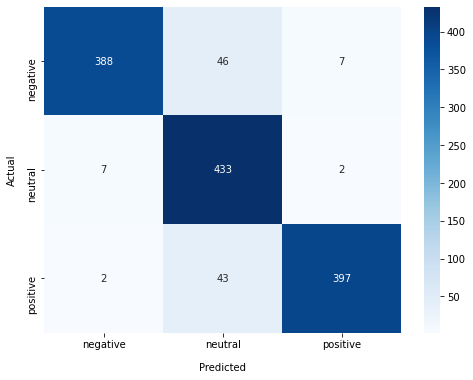

In [71]:
prediction(lr,X_train_ngram,y_train,X_val_ngram,y_val)

In [72]:
mod14 = prediction.results
mod14

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.919245,0.928184,0.919245,0.920221,0.98007


### Random Forest

              precision    recall  f1-score   support

          -1       0.92      0.90      0.91       441
           0       0.86      0.93      0.89       442
           1       0.97      0.91      0.94       442

    accuracy                           0.91      1325
   macro avg       0.92      0.91      0.91      1325
weighted avg       0.92      0.91      0.91      1325



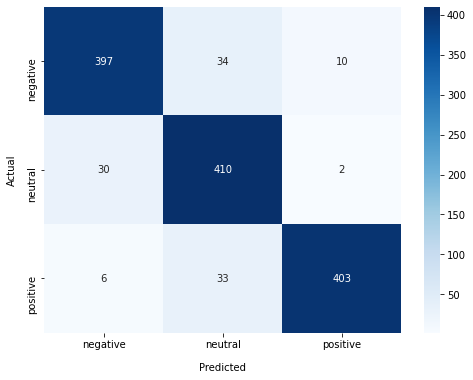

In [73]:
prediction(rf,X_train_ngram,y_train,X_val_ngram,y_val)

In [74]:
mod15 = prediction.results
mod15

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.913208,0.915827,0.913208,0.913748,0.972846


### Support Vector Machine

              precision    recall  f1-score   support

          -1       0.98      0.90      0.94       441
           0       0.86      0.98      0.92       442
           1       0.98      0.92      0.95       442

    accuracy                           0.94      1325
   macro avg       0.94      0.94      0.94      1325
weighted avg       0.94      0.94      0.94      1325



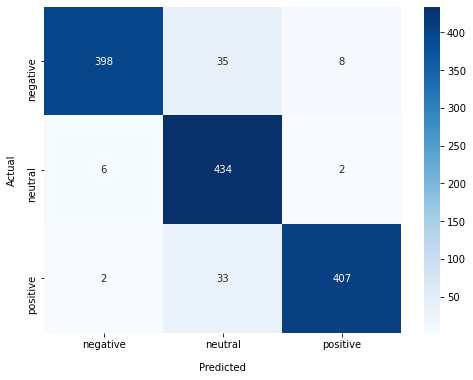

In [75]:
prediction(svm,X_train_ngram,y_train,X_val_ngram,y_val)

In [76]:
mod16 = prediction.results
mod16

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.935094,0.940255,0.935094,0.935628,0.982991


## TFIDF Unigram

### Naive Bayes

              precision    recall  f1-score   support

          -1       0.85      0.90      0.87       441
           0       0.86      0.74      0.80       442
           1       0.86      0.93      0.89       442

    accuracy                           0.86      1325
   macro avg       0.86      0.86      0.86      1325
weighted avg       0.86      0.86      0.86      1325



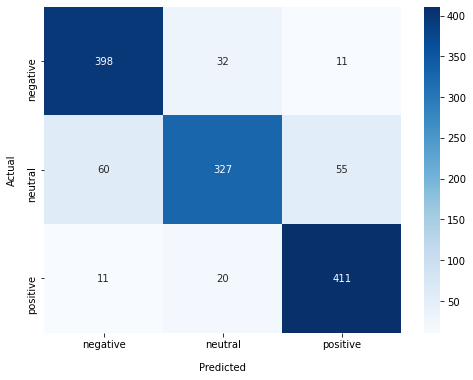

In [77]:
prediction(nb,X_train_tfidf1,y_train,X_val_tfidf1,y_val)

In [78]:
mod17 = prediction.results
mod17

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.857358,0.857689,0.857358,0.85524,0.965903


### Logistic Regression

              precision    recall  f1-score   support

          -1       0.96      0.89      0.93       441
           0       0.83      0.97      0.90       442
           1       0.98      0.90      0.94       442

    accuracy                           0.92      1325
   macro avg       0.93      0.92      0.92      1325
weighted avg       0.93      0.92      0.92      1325



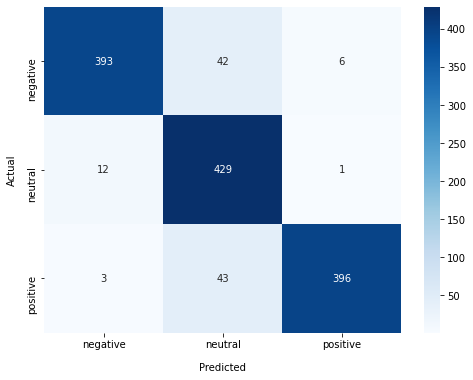

In [79]:
prediction(lr,X_train_tfidf1,y_train,X_val_tfidf1,y_val)

In [80]:
mod18 = prediction.results
mod18

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.919245,0.926804,0.919245,0.920183,0.981435


### Random Forest

              precision    recall  f1-score   support

          -1       0.97      0.91      0.94       441
           0       0.87      0.98      0.92       442
           1       0.97      0.92      0.95       442

    accuracy                           0.94      1325
   macro avg       0.94      0.94      0.94      1325
weighted avg       0.94      0.94      0.94      1325



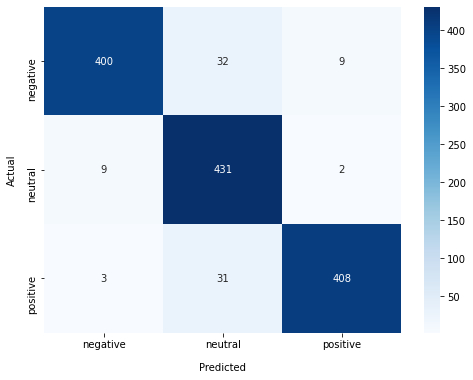

In [81]:
prediction(rf,X_train_tfidf1,y_train,X_val_tfidf1,y_val)

In [82]:
mod19 = prediction.results
mod19

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.935094,0.939006,0.935094,0.935512,0.977314


### Support Vector Machine

              precision    recall  f1-score   support

          -1       0.98      0.91      0.94       441
           0       0.86      0.98      0.92       442
           1       0.98      0.92      0.95       442

    accuracy                           0.94      1325
   macro avg       0.94      0.94      0.94      1325
weighted avg       0.94      0.94      0.94      1325



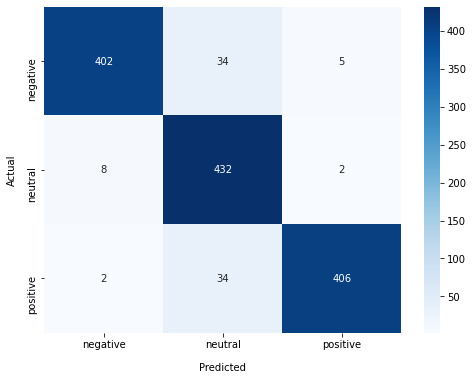

In [83]:
prediction(svm,X_train_tfidf1,y_train,X_val_tfidf1,y_val)

In [84]:
mod20 = prediction.results
mod20

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.935849,0.9409,0.935849,0.936482,0.983299


## TFIDF Bigrams

### Naive Bayes

              precision    recall  f1-score   support

          -1       0.86      0.89      0.87       441
           0       0.84      0.80      0.82       442
           1       0.90      0.90      0.90       442

    accuracy                           0.87      1325
   macro avg       0.87      0.87      0.87      1325
weighted avg       0.87      0.87      0.87      1325



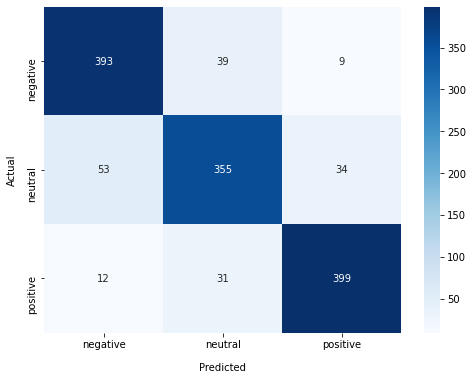

In [85]:
prediction(nb,X_train_tfidf2,y_train,X_val_tfidf2,y_val)

In [86]:
mod21 = prediction.results
mod21

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.86566,0.865368,0.86566,0.865305,0.963388


### Logistic Regression

              precision    recall  f1-score   support

          -1       0.97      0.88      0.92       441
           0       0.83      0.97      0.89       442
           1       0.98      0.90      0.94       442

    accuracy                           0.92      1325
   macro avg       0.92      0.92      0.92      1325
weighted avg       0.92      0.92      0.92      1325



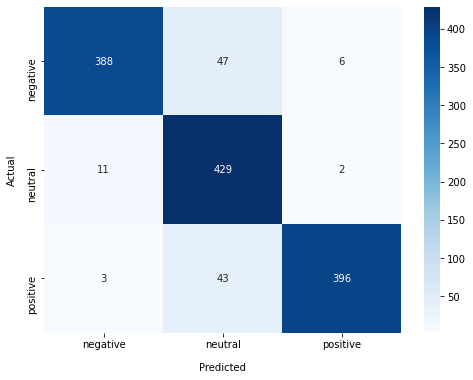

In [87]:
prediction(lr,X_train_tfidf2,y_train,X_val_tfidf2,y_val)

In [88]:
mod22 = prediction.results
mod22

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.915472,0.923956,0.915472,0.916501,0.977988


### Random Forest

              precision    recall  f1-score   support

          -1       0.97      0.91      0.94       441
           0       0.88      0.97      0.92       442
           1       0.97      0.92      0.94       442

    accuracy                           0.93      1325
   macro avg       0.94      0.93      0.93      1325
weighted avg       0.94      0.93      0.93      1325



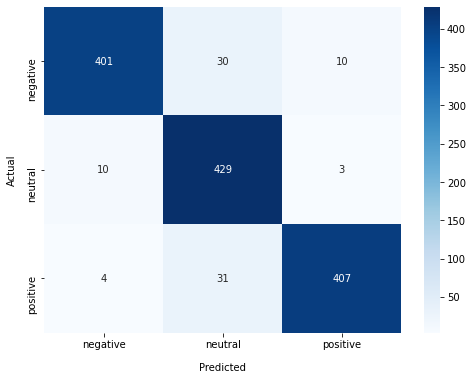

In [89]:
prediction(rf,X_train_tfidf2,y_train,X_val_tfidf2,y_val)

In [90]:
mod23 = prediction.results
mod23

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.933585,0.936919,0.933585,0.933942,0.975785


### SVM

              precision    recall  f1-score   support

          -1       0.97      0.89      0.93       441
           0       0.85      0.97      0.91       442
           1       0.98      0.92      0.95       442

    accuracy                           0.93      1325
   macro avg       0.93      0.93      0.93      1325
weighted avg       0.93      0.93      0.93      1325



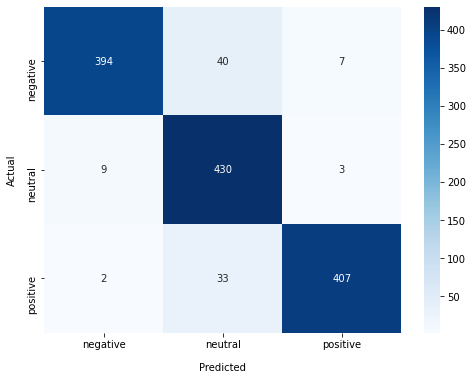

In [91]:
prediction(svm,X_train_tfidf2,y_train,X_val_tfidf2,y_val)

In [92]:
mod24 = prediction.results
mod24

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.929057,0.934548,0.929057,0.929702,0.980009


# Section 10: Summarised Results Tables

### Feature Presence

In [93]:
models = ["Multinomial NB","Logistic Regression","Random Forest","Support Vector Machine"]

model_summary_fp = pd.concat([mod1,mod2,mod3,mod4])
model_summary_fp.set_index([models],inplace = True)
model_summary_fp
model_summary_fp.sort_values(by = "ROCAUC",ascending = False)

,Accuracy,Precision,Recall,F1,ROCAUC
Support Vector Machine,0.944906,0.948445,0.944906,0.945230,0.983808
Logistic Regression,0.924528,0.931483,0.924528,0.925307,0.982370
Random Forest,0.916981,0.918075,0.916981,0.917273,0.974500
Multinomial NB,0.853585,0.854293,0.853585,0.851283,0.969222


### Feature Presence Ngram

In [94]:
models = ["Multinomial NB","Logistic Regression","Random Forest","Support Vector Machine"]

model_summary_fp_ngram = pd.concat([mod5,mod6,mod7,mod8])
model_summary_fp_ngram.set_index([models],inplace = True)
model_summary_fp_ngram
model_summary_fp_ngram.sort_values(by = "ROCAUC",ascending = False)

,Accuracy,Precision,Recall,F1,ROCAUC
Support Vector Machine,0.935849,0.940847,0.935849,0.936369,0.983461
Logistic Regression,0.916981,0.926546,0.916981,0.918007,0.980541
Random Forest,0.912453,0.915363,0.912453,0.912957,0.972867
Multinomial NB,0.855849,0.855753,0.855849,0.853956,0.965757


### BOWs

In [95]:
models = ["Multinomial NB","Logistic Regression","Random Forest","Support Vector Machine"]

model_summary_bow = pd.concat([mod9,mod10,mod11,mod12])
model_summary_bow.set_index([models],inplace = True)
model_summary_bow
model_summary_bow.sort_values(by = "ROCAUC",ascending = False)

,Accuracy,Precision,Recall,F1,ROCAUC
Support Vector Machine,0.944906,0.948445,0.944906,0.945230,0.983321
Logistic Regression,0.924528,0.931483,0.924528,0.925307,0.981869
Random Forest,0.914717,0.916204,0.914717,0.915055,0.975065
Multinomial NB,0.855094,0.855583,0.855094,0.852840,0.968770


In [96]:
# Save to csv
#model_summary_bow.to_csv("model_summary_bow.csv")

### BOW Ngram

In [97]:
model_summary_bow_ngram = pd.concat([mod13, mod14, mod15, mod16])
model_summary_bow_ngram.set_index([models],inplace = True)
model_summary_bow_ngram.sort_values(by = "ROCAUC",ascending = False)
model_summary_bow_ngram

,Accuracy,Precision,Recall,F1,ROCAUC
Multinomial NB,0.857358,0.857340,0.857358,0.855501,0.965188
Logistic Regression,0.919245,0.928184,0.919245,0.920221,0.980070
Random Forest,0.913208,0.915827,0.913208,0.913748,0.972846
Support Vector Machine,0.935094,0.940255,0.935094,0.935628,0.982991


In [98]:
# Save to csv
#model_summary_ngram.to_csv("model_summary_ngram.csv")

### TFIDF 

In [99]:
model_summary_tfidf1 = pd.concat([mod17, mod18, mod19, mod20])
model_summary_tfidf1.set_index([models],inplace = True)
model_summary_tfidf1.sort_values(by = "ROCAUC",ascending = False)
model_summary_tfidf1

,Accuracy,Precision,Recall,F1,ROCAUC
Multinomial NB,0.857358,0.857689,0.857358,0.855240,0.965903
Logistic Regression,0.919245,0.926804,0.919245,0.920183,0.981435
Random Forest,0.935094,0.939006,0.935094,0.935512,0.977314
Support Vector Machine,0.935849,0.940900,0.935849,0.936482,0.983299


In [100]:
# Save to csv
#model_summary_tfidf1.to_csv("model_summary_tfidf_bow.csv")

### TFIDF Ngram

In [101]:
model_summary_tfidf2 = pd.concat([mod21, mod22, mod23, mod24])
model_summary_tfidf2.set_index([models],inplace = True)
model_summary_tfidf2.sort_values(by = "ROCAUC",ascending = False)
model_summary_tfidf2

,Accuracy,Precision,Recall,F1,ROCAUC
Multinomial NB,0.865660,0.865368,0.865660,0.865305,0.963388
Logistic Regression,0.915472,0.923956,0.915472,0.916501,0.977988
Random Forest,0.933585,0.936919,0.933585,0.933942,0.975785
Support Vector Machine,0.929057,0.934548,0.929057,0.929702,0.980009


### Summary of all models

In [102]:
all_ml_models = pd.concat([model_summary_fp,model_summary_fp_ngram,model_summary_bow,model_summary_bow_ngram,model_summary_tfidf1,model_summary_tfidf2])
all_ml_models.index = ['Multinomial NB FP', 'Logistic Regression FP', 'Random Forest FP','Support Vector Machine FP',
                       'Multinomial NB FP BIG', 'Logistic Regression FP BIG', 'Random Forest FP BIG','Support Vector Machine FP BIG',
                       'Multinomial NB BOW', 'Logistic Regression BOW', 'Random Forest BOW',
                       'Support Vector Machine BOW','Multinomial NB BIG', 'Logistic Regression BIG', 'Random Forest BIG',
                       'Support Vector Machine BIG','Multinomial NB TFIDF', 'Logistic Regression TFIDF', 'Random Forest TFIDF',
                       'Support Vector Machine TFIDF','Multinomial NB TFIDF BIG', 'Logistic Regression TFIDF BIG', 'Random Forest TFIDF BIG',
                       'Support Vector Machine TFIDF BIG']

In [103]:
# Sorted by Accuracy
all_ml_models.sort_values(by = "ROCAUC",ascending = False)

,Accuracy,Precision,Recall,F1,ROCAUC
Support Vector Machine FP,0.944906,0.948445,0.944906,0.945230,0.983808
Support Vector Machine FP BIG,0.935849,0.940847,0.935849,0.936369,0.983461
Support Vector Machine BOW,0.944906,0.948445,0.944906,0.945230,0.983321
Support Vector Machine TFIDF,0.935849,0.940900,0.935849,0.936482,0.983299
Support Vector Machine BIG,0.935094,0.940255,0.935094,0.935628,0.982991
Logistic Regression FP,0.924528,0.931483,0.924528,0.925307,0.982370
Logistic Regression BOW,0.924528,0.931483,0.924528,0.925307,0.981869
Logistic Regression TFIDF,0.919245,0.926804,0.919245,0.920183,0.981435
Logistic Regression FP BIG,0.916981,0.926546,0.916981,0.918007,0.980541
Logistic Regression BIG,0.919245,0.928184,0.919245,0.920221,0.980070


In [104]:
# Sorted by recall
all_ml_models.sort_values(by = "Accuracy",ascending = False).head(5)

,Accuracy,Precision,Recall,F1,ROCAUC
Support Vector Machine FP,0.944906,0.948445,0.944906,0.945230,0.983808
Support Vector Machine BOW,0.944906,0.948445,0.944906,0.945230,0.983321
Support Vector Machine FP BIG,0.935849,0.940847,0.935849,0.936369,0.983461
Support Vector Machine TFIDF,0.935849,0.940900,0.935849,0.936482,0.983299
Random Forest TFIDF,0.935094,0.939006,0.935094,0.935512,0.977314


In [105]:
# Sorted by F1-score
all_ml_models.sort_values(by = "F1",ascending = False).head(5)

,Accuracy,Precision,Recall,F1,ROCAUC
Support Vector Machine FP,0.944906,0.948445,0.944906,0.945230,0.983808
Support Vector Machine BOW,0.944906,0.948445,0.944906,0.945230,0.983321
Support Vector Machine TFIDF,0.935849,0.940900,0.935849,0.936482,0.983299
Support Vector Machine FP BIG,0.935849,0.940847,0.935849,0.936369,0.983461
Support Vector Machine BIG,0.935094,0.940255,0.935094,0.935628,0.982991


In [106]:
# Sorted by ROCAUC
all_ml_models.sort_values(by = "Recall",ascending = False).head()

,Accuracy,Precision,Recall,F1,ROCAUC
Support Vector Machine FP,0.944906,0.948445,0.944906,0.945230,0.983808
Support Vector Machine BOW,0.944906,0.948445,0.944906,0.945230,0.983321
Support Vector Machine FP BIG,0.935849,0.940847,0.935849,0.936369,0.983461
Support Vector Machine TFIDF,0.935849,0.940900,0.935849,0.936482,0.983299
Random Forest TFIDF,0.935094,0.939006,0.935094,0.935512,0.977314


In [107]:
final_text_models = all_ml_models.sort_values(by = "ROCAUC",ascending = False)
final_text_models.to_csv("TextSentimentModels.csv")

# Section 11: Hyperparameter Tuning

In [37]:
best_model = SVC(probability = True)
best_model.get_params().keys()

dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

In [38]:
# Using feature presence - no need to use weighting as balanced classes but one versus rest roc auc score as multiclass
# cv reduced to 5 as model struggling to run
params = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid','linear']}
clf = GridSearchCV(best_model,param_grid = params, cv = 5, scoring = 'roc_auc_ovr')

In [39]:
clf.fit(X_train_fp,y_train)

GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             scoring='roc_auc_ovr')

In [40]:
# Get results
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best score: {results.best_score_}')
    print(f'Best estimator: {results.best_estimator_}')
    print("\n")
    
display(clf)

Best parameters are: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best score: 0.9838867723718311
Best estimator: SVC(C=100, gamma=0.01, probability=True)




# Section 12: Hyperparameter Tuning Then Used Against the Test Set

In [42]:
# Set up the best model
best_model = SVC(C=100, gamma=0.01,kernel='rbf', probability = True)

              precision    recall  f1-score   support

          -1       0.98      0.90      0.94       441
           0       0.91      0.99      0.95       442
           1       0.97      0.96      0.96       441

    accuracy                           0.95      1324
   macro avg       0.95      0.95      0.95      1324
weighted avg       0.95      0.95      0.95      1324



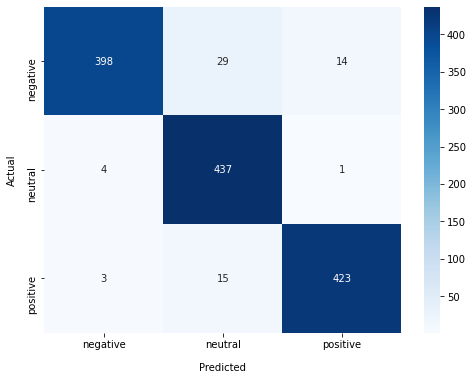

In [47]:
prediction(best_model,X_train_fp,y_train,X_test_fp,y_test)

In [48]:
best_model_results = prediction.results
best_model_results

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.950151,0.952331,0.950122,0.950089,0.985127


In [49]:
filename = 'multiclasssentiment_model.sav'
pickle.dump(best_model, open(filename, 'wb'))